<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="300" alt="Skills Network Logo">
    </a>
</p>


# **Hands-on Practice Lab: Model Evaluation and Refinement**

Estimated time needed: **45** minutes

In this lab, you will use the skills acquired throughout the module, and try to refine your model's performance in predicting the price of a laptop, given the attribute values.


# Objectives

After completing this lab you will be able to:

 - Use training, testing and cross validation to improve the performance of the dataset. 
 - Identify the point of overfitting of a model
 - Use Ridge Regression to identify the change in performance of a model based on its hyperparameters
 - Use Grid Search to identify the best performing model using different hyperparameters


# Setup


For this lab, we will be using the following libraries:

* `skillsnetwork` for downloading the dataset
*   [`pandas`](https://pandas.pydata.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for managing the data.
*   [`numpy`](https://numpy.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for mathematical operations.
*   [`sklearn`](https://scikit-learn.org/stable/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for machine learning and machine-learning-pipeline related functions.
*   [`seaborn`](https://seaborn.pydata.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for visualizing the data.
*   [`matplotlib`](https://matplotlib.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for additional plotting tools.


### Installing Required Libraries

The following required libraries are pre-installed in the Skills Network Labs environment. However, if you run this notebook commands in a different Jupyter environment (e.g. Watson Studio or Ananconda), you will need to install these libraries by removing the `#` sign before `%pip` in the code cell below.


The following required libraries are __not__ pre-installed in the Skills Network Labs environment. __You will need to run the following cell__ to install them:


In [1]:
import piplite
await piplite.install('seaborn')

### Importing Required Libraries

_We recommend you import all required libraries in one place (here):_


In [2]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures

<ipython-input-2-4b1dc37464fb>:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Importing the Dataset

Run the cell below to donwload the dataset into the console.


In [3]:
from pyodide.http import pyfetch

async def download(url, filename):
    response = await pyfetch(url)
    if response.status == 200:
        with open(filename, "wb") as f:
            f.write(await response.bytes())

In [4]:
filepath = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DA0101EN-Coursera/laptop_pricing_dataset_mod2.csv'

In [5]:
await download(filepath, "laptops.csv")
file_name="laptops.csv"

In [6]:
df = pd.read_csv(file_name, header=0)

> Note: This version of the lab is working on JupyterLite, which requires the dataset to be downloaded to the interface.While working on the downloaded version of this notebook on their local machines(Jupyter Anaconda), the learners can simply **skip the steps above,** and simply use the URL directly in the `pandas.read_csv()` function. You can uncomment and run the statements in the cell below.


Import the data set into a data frame.


In [7]:
#filepath = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DA0101EN-Coursera/laptop_pricing_dataset_mod2.csv'
#df = pd.read_csv(filepath, header=None)

Print the value of df.head(). 


In [8]:
df.head()

,Unnamed: 0.1,Unnamed: 0,Manufacturer,Category,GPU,OS,CPU_core,Screen_Size_inch,CPU_frequency,RAM_GB,Storage_GB_SSD,Weight_pounds,Price,Price-binned,Screen-Full_HD,Screen-IPS_panel
0,0,0,Acer,4,2,1,5,14.0,0.551724,8,256,3.52800,978,Low,0,1
1,1,1,Dell,3,1,1,3,15.6,0.689655,4,256,4.85100,634,Low,1,0
2,2,2,Dell,3,1,1,7,15.6,0.931034,8,256,4.85100,946,Low,1,0
3,3,3,Dell,4,2,1,5,13.3,0.551724,8,128,2.69010,1244,Low,0,1
4,4,4,HP,4,2,1,7,15.6,0.620690,8,256,4.21155,837,Low,1,0


Drop the two unnecessary columns that have been added into the file, 'Unnamed: 0' and 'Unnamed: 0.1'. Use drop to delete these columns.


In [9]:
df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)

# Task 1 : Using Cross validation to improve the model

Divide the dataset into x_data and y_data parameters. Here y_data is the "Price" attribute, and x_data has all other attributes in the data set.


In [10]:
# Write your code below and press Shift+Enter to execute 
y_data = df['Price']
x_data = df.drop('Price', axis=1)

<details><summary>Click here for the solution</summary>

```python
y_data = df['Price']
x_data = df.drop('Price',axis=1)
```

</details>


Split the data set into training and testing subests such that you reserve 10% of the data set for testing purposes.


In [13]:
# Write your code below and press Shift+Enter to execute 
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.10, random_state=1)
print("Number of test samples:", x_test.shape[0])
print("Number of training samples:", x_train.shape[0])

Number of test samples: 24
Number of training samples: 214


<details><summary>Click here for the solution</summary>

```python
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.10, random_state=1)
print("number of test samples :", x_test.shape[0])
print("number of training samples:",x_train.shape[0])
```

</details>


Create a single variable linear regression model using "CPU_frequency" parameter. Print the R^2 value of this model for the training and testing subsets.


In [15]:
# Write your code below and press Shift+Enter to execute 
lre = LinearRegression()
lre.fit(x_train[['CPU_frequency']], y_train)
print(lre.score(x_test[['CPU_frequency']], y_test))
print(lre.score(x_train[['CPU_frequency']], y_train))

-0.06599437350393766
0.14829792099817962


<details><summary>Click here for the solution</summary>

```python
lre=LinearRegression()
lre.fit(x_train[['CPU_frequency']], y_train)
print(lre.score(x_test[['CPU_frequency']], y_test))
print(lre.score(x_train[['CPU_frequency']], y_train))
```

</details>


Run a 4-fold cross validation on the model and print the mean value of R^2 score along with its standard deviation.


In [23]:
# Write your code below and press Shift+Enter to execute 
Rcross = cross_val_score(lre, x_data[['CPU_frequency']], y_data, cv=4)
print("The mean of the folds are", Rcross.mean(), "and the standard deviation is", Rcross.std())

The mean of the folds are -0.1610923238859522 and the standard deviation is 0.38495797866647274


<details><summary>Click here for the solution</summary>

```python
Rcross = cross_val_score(lre, x_data[['CPU_frequency']], y_data, cv=4)
print("The mean of the folds are", Rcross.mean(), "and the standard deviation is" , Rcross.std())
```

</details>


# Task 2: Overfitting

Split the data set into training and testing components again, this time reserving 50% of the data set for testing.


In [26]:
# Write your code below and press Shift+Enter to execute 
x_test, x_train, y_test, y_train = train_test_split(x_data, y_data, test_size=0.50, random_state=0)

<details><summary>Click here for the solution</summary>

```python
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.5, random_state=0)
# fixing random_state to a fixed quantity helps maintain uniformity between multiple 
# executions of the code.
```

</details>


To identify the point of overfitting the model on the parameter "CPU_frequency", you'll need to create polynomial features using the single attribute. 
You need to evaluate the R^2 scores of the model created using different degrees of polynomial features, ranging from 1 to 5. Save this set of values of R^2 score as a list.


In [28]:
# Write your code below and press Shift+Enter to execute 
lre = LinearRegression()
Rsqu_test = []
order = [1, 2, 3, 4, 5]
for n in order:
    pr = PolynomialFeatures(degree=n)
    x_train_pr = pr.fit_transform(x_train[['CPU_frequency']])
    x_test_pr = pr.fit_transform(x_test[['CPU_frequency']])
    lre.fit(x_train_pr, y_train)
    Rsqu_test.append(lre.score(x_test_pr, y_test))

<details><summary>Click here for the solution</summary>

```python
lre = LinearRegression()
Rsqu_test = []
order = [1, 2, 3, 4, 5]
for n in order:
    pr = PolynomialFeatures(degree=n)
    x_train_pr = pr.fit_transform(x_train[['CPU_frequency']])
    x_test_pr = pr.fit_transform(x_test[['CPU_frequency']])    
    lre.fit(x_train_pr, y_train)
    Rsqu_test.append(lre.score(x_test_pr, y_test))
```

</details>


Plot the values of R^2 scores against the order. Note the point where the score drops.


Text(0.5, 1.0, 'R SQUARE TEST DATA')

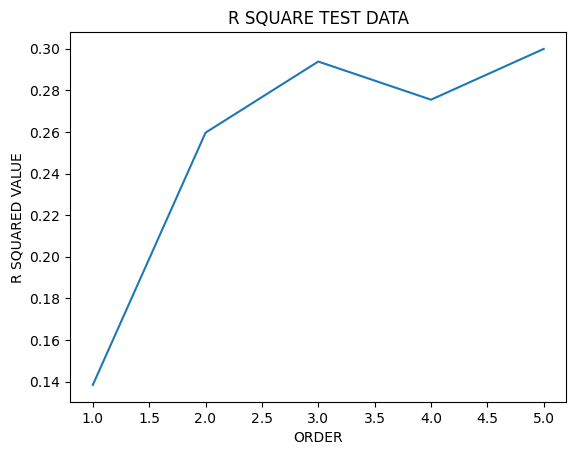

In [29]:
# Write your code below and press Shift+Enter to execute 
plt.plot(order, Rsqu_test)
plt.xlabel("ORDER")
plt.ylabel("R SQUARED VALUE")
plt.title("R SQUARE TEST DATA")

<details><summary>Click here for the solution</summary>

```python
plt.plot(order, Rsqu_test)
plt.xlabel('order')
plt.ylabel('R^2')
plt.title('R^2 Using Test Data')
```

</details>


# Task 3 : Ridge Regression

Now consider that you have multiple features, i.e. 'CPU_frequency', 'RAM_GB', 'Storage_GB_SSD', 'CPU_core','OS','GPU' and 'Category'. Create a polynomial feature model that uses all these parameters with degree=2. Also create the training and testing attribute sets.


In [32]:
# Write your code below and press Shift+Enter to execute 
pr = PolynomialFeatures(degree=2)
x_train_pr = pr.fit_transform(x_train[['CPU_frequency', 'RAM_GB', 'Storage_GB_SSD', 'CPU_core', 'OS', 'GPU', 'Category']])
x_test_pr = pr.fit_transform(x_test[['CPU_frequency', 'RAM_GB', 'Storage_GB_SSD', 'CPU_core', 'OS', 'GPU', 'Category']])

<details><summary>Click here for the solution</summary>

```python
pr=PolynomialFeatures(degree=2)
x_train_pr=pr.fit_transform(x_train[['CPU_frequency', 'RAM_GB', 'Storage_GB_SSD', 'CPU_core', 'OS', 'GPU', 'Category']])
x_test_pr=pr.fit_transform(x_test[['CPU_frequency', 'RAM_GB', 'Storage_GB_SSD', 'CPU_core', 'OS', 'GPU', 'Category']])
```

</details>


Create a Ridge Regression model and evaluate it using values of the hyperparameter alpha ranging from 0.001 to 1 with increments of 0.001. 
Create a list of all Ridge Regression R^2 scores for training and testing data. 


In [33]:
# Write your code below and press Shift+Enter to execute 
Rsqu_test = []
Rsqu_train = []
Alpha = np.arange(0.001, 1, 0.001)
pbar = tqdm(Alpha)

for alpha in pbar:
    RidgeModel = Ridge(alpha=alpha)
    RidgeModel.fit(x_train_pr, y_train)
    test_score, train_score = RidgeModel.score(x_test_pr, y_test), RidgeModel.score(x_train_pr, y_train)
    Rsqu_test.append(test_score)
    Rsqu_train.append(train_score)

<ipython-input-33-ec6f1fe1d229>:5: TqdmMonitorWarning: tqdm:disabling monitor support (monitor_interval = 0) due to:
can't start new thread
  pbar = tqdm(Alpha)
100%|██████████| 999/999 [00:02<00:00, 449.39it/s]


<details><summary>Click here for the solution</summary>

```python
Rsqu_test = []
Rsqu_train = []
Alpha = np.arange(0.001,1,0.001)
pbar = tqdm(Alpha)

for alpha in pbar:
    RigeModel = Ridge(alpha=alpha) 
    RigeModel.fit(x_train_pr, y_train)
    test_score, train_score = RigeModel.score(x_test_pr, y_test), RigeModel.score(x_train_pr, y_train)
    pbar.set_postfix({"Test Score": test_score, "Train Score": train_score})
    Rsqu_test.append(test_score)
    Rsqu_train.append(train_score)
```

</details>


Plot the R^2 values for training and testing sets with respect to the value of alpha


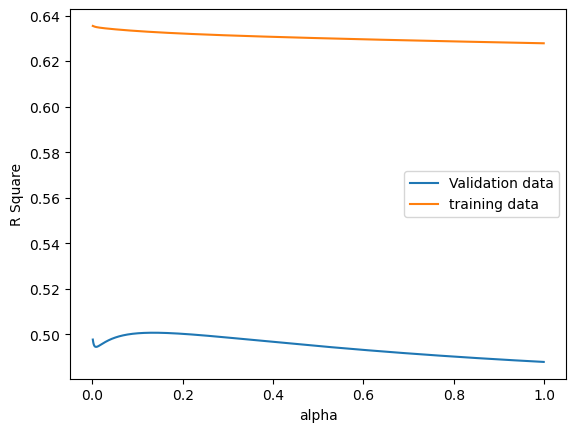

In [36]:
# Write your code below and press Shift+Enter to execute 
plt.plot(Alpha, Rsqu_test, label='Validation data')
plt.plot(Alpha, Rsqu_train, label='training data')
plt.xlabel('alpha')
plt.ylabel('R Square')
plt.legend() 

<details><summary>Click here for the solution</summary>

```python
plt.figure(figsize=(10, 6))  
plt.plot(Alpha, Rsqu_test, label='validation data')
plt.plot(Alpha, Rsqu_train, 'r', label='training Data')
plt.xlabel('alpha')
plt.ylabel('R^2')
plt.ylim(0, 1)
plt.legend()
```

</details>


# Task 4: Grid Search

Using the raw data and the same set of features as used above, use GridSearchCV to identify the value of alpha for which the model performs best. 
Assume the set of alpha values to be used as
```math
{0.0001, 0.001, 0.01, 0.1, 1, 10}
```


In [37]:
# Write your code below and press Shift+Enter to execute 
parameters1 = [{'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]}]

<details><summary>Click here for the solution</summary>

```python
parameters1= [{'alpha': [0.0001,0.001,0.01, 0.1, 1, 10]}]
```

</details>


Create a Ridge instance and run Grid Search using a 4 fold cross validation.


In [38]:
# Write your code below and press Shift+Enter to execute 
RR = Ridge()
Grid1 = GridSearchCV(RR, parameters1, cv=4)

<details><summary>Click here for the solution</summary>

```python
RR=Ridge()
Grid1 = GridSearchCV(RR, parameters1,cv=4)
```
</details>


Fit the Grid Search to the training data.


In [39]:
Grid1.fit(x_train[['CPU_frequency', 'RAM_GB', 'Storage_GB_SSD', 'CPU_core', 'OS', 'GPU', 'Category']], y_train)

GridSearchCV(cv=4, estimator=Ridge(),
             param_grid=[{'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]}])

<details><summary>Click here for the solution</summary>

```python
Grid1.fit(x_train[['CPU_frequency', 'RAM_GB', 'Storage_GB_SSD', 'CPU_core', 'OS', 'GPU', 'Category']], y_train)
```
</details>


Print the R^2 score for the test data using the estimator that uses the derived optimum value of alpha.


In [41]:
# Write your code below and press Shift+Enter to execute 
BestRR=Grid1.best_estimator_
print(BestRR.score(x_test[['CPU_frequency', 'RAM_GB', 'Storage_GB_SSD', 'CPU_core', 'OS', 'GPU', 'Category']], y_test))

0.5120195210771199


<details><summary>Click here for the solution</summary>

```python
BestRR=Grid1.best_estimator_
print(BestRR.score(x_test[['CPU_frequency', 'RAM_GB', 'Storage_GB_SSD', 'CPU_core','OS','GPU','Category']], y_test))
```
</details>


# Congratulations! You have completed the lab


## Authors


[Abhishek Gagneja](https://www.coursera.org/instructor/~129186572)

[Vicky Kuo](https://author.skills.network/instructors/vicky_kuo)


Copyright © 2023 IBM Corporation. All rights reserved.


<!--## Change Log


<!--|Date (YYYY-MM-DD)|Version|Changed By|Change Description|
|-|-|-|-|
|2023-09-16|0.1|Abhishek Gagneja|Initial Version Created|
|2023-09-19|0.2|Vicky Kuo|Reviewed and Revised|
--!>
